0. 项目介绍
1. 数据获取
2. 数据探索
3. 数据规范化
4. 数据集划分
5. 采用欠采样的方式（NearMiss算法）进行模型创建、训练与评估
6. 采用过采样的方式（SMOTE算法）进行模型创建、训练与评估
7. 总结

# 0. 项目介绍

## 0.1 背景
数据集包含欧洲持卡人于2013年9月通过信用卡进行的交易。该数据集提供两天内发生的交易，其中在284,807笔交易中有492起欺诈行为。
**数据集非常不平衡，负面类别（欺诈）占所有交易的0.172％。**

数据集只包含数值输入变量，这是PCA变换的结果。遗憾的是，由于保密问题，我们无法提供有关数据的原始特征和更多背景信息。
特征V1，V2，... V28是经过PCA转换的，**唯一没有用PCA转换的特征是'Time'和'Amount'。**

- 'Time'包含每个交易与数据集中第一个交易之间经过的秒数。
- 'Amount'是交易金额
- 'Class'是标签，在欺诈的情况下其值为1，否则为0。

## 0.2 纠正以前关于不平衡数据集的错误想法
- 不要在过采样或者欠采样的数据集上进行测试。
- 如果我们想实现交叉验证，请记住**在交叉验证期间(而不是在此之前)对训练数据进行过采样或欠采样!**
- 在不平衡的数据集上不要使用准确度作为度量(准确度通常会很高而且会误导)，而是**使用f1-score, precision/recall score或confusion matrix。**

# 1. 数据获取
## 1.1 导入相应库

In [1]:
# 导入常用库
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# 分类器
from sklearn.linear_model import LogisticRegression

# 其他库
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, RandomizedSearchCV
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix, precision_recall_curve, average_precision_score
import itertools
plt.rcParams['font.sans-serif'] = ['SimHei']

## 1.2 导入数据

In [2]:
df = pd.read_csv('./creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# 2. 数据探索

In [3]:
# （1）查看描述性统计分析: Amount 和 Time 没有缩放
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
# （2）查看是否有缺失值,在这里是没有缺失值的，所以不用考虑缺失值
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [5]:
# （3）#查看列名
df.columns


Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [6]:
# （4）数据集严重不平衡，需解决这个问题。
print("No Frauds", round(df['Class'].value_counts()[0] / len(df) * 100, 2), '% of the dataset')
print("Frauds", round(df['Class'].value_counts()[1] / len(df) * 100, 2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

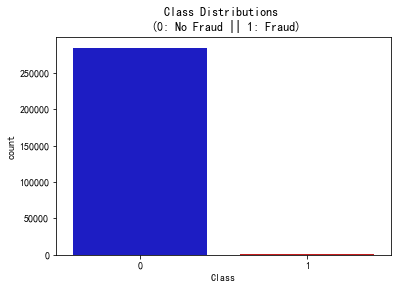

In [7]:
# （5）#对标签进行画图，直观地表示正负类比例
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data = df, palette = colors)
plt.title("Class Distributions \n (0: No Fraud || 1: Fraud)")

根据上图：
- 注意我们的原始数据集是很不平衡的。大部分交易是非欺诈的。
- 如果我们使用这个数据集作为我们预测模型和分析的基础，我们可能会得到很多错误，模型也可能会过拟合，因为这个数据集会使模型假定大多数交易是非欺诈的。
- 但我们不想模型进行这样的假定，而是想检测出欺诈的规律。

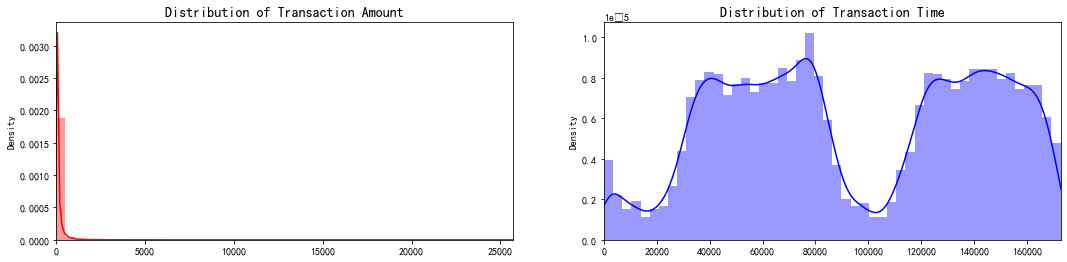

In [8]:
# （6）对金额Amount,时间Time进行画图
fig,ax = plt.subplots(1, 2, figsize = (18, 4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax = ax[0], color = 'r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])


plt.show()

# 3. 数据规范化
- 数据没有缺失值。
- 我们将首先缩放由时间'time'和金额'amount'组成的列。时间和金额应该像其他列一样缩放。

In [9]:
# （1）对 Time 和 Amount 列进行缩放
# StandardScaler函数用于标准化数据，使数据每一个特征的均值为0，方差为1。也就是说，该函数用于使数据的分布变成标准正态分布。
std_scaler = StandardScaler()
#  RobustScaler 函数使用对异常值鲁棒的统计信息来缩放特征。这个标量去除中值，并根据分位数范围(默认为IQR即四分位数范围)对数据进行缩放。
#  IQR是第1个四分位数(第25分位数)和第3个四分位数(第75分位数)之间的范围。通过计算训练集中样本的相关统计量，对每个特征分别进行定心和缩放。然后将中值和四分位范围存储起来，使用“变换”方法用于以后的数据。
rob_scaler = RobustScaler()

# reshape(-1,1)表示转换成1行
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1, 1))

df.drop(['Time', 'Amount'], axis=1, inplace=True)

In [10]:
# 这里只是为了将缩放的两列放到第一第二列，便于观察
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


# 4. 数据集划分
- 在进行欠采样之前，我们必须将原始数据集分割成训练集和测试集，因为我们**最后进行测试是在原始的测试集上进行测试，而不是在欠采样或者过采样后所创建的测试集上测试。**
- 我们的主要目的是用过采样或者欠采样后的数据去训练模型，然后在原始数据的测试集上进行测试。

In [11]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

# 划分特征和标签
X = df.drop('Class', axis = 1)
y = df['Class']

# StratifiedKFold则是在KFold的基础上，加入了分层抽样的思想，使得测试集和训练集有相同的数据分布。
# 因此表现在算法上，StratifiedKFold需要同时输入数据和标签，便于统一训练集和测试集的分布。
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# 转化为 array 类型数据
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# 检查划分后数据集的结构，确保训练集、测试集中的X、y的数量一一对应
# np.unique() 函数 去除其中重复的元素 ，并按元素 由小到大 返回一个新的无元素重复的元组或者列表。
# return_counts：如果为 true，返回去重数组中的元素在原数组中的出现次数。
# 以下 ..._unique_label 结果为0和1；..._counts_label 中为0和1的数量。
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label / len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


# 5. 采用欠采样的方式（NearMiss算法）进行模型创建、训练与评估

In [12]:
# 我们将在交叉验证期间进行欠采样(这里是用NearMiss算法进行的欠采样)

undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]

undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]


## 5.1 欠采样模型创建

In [13]:
log_reg = LogisticRegression()

log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)

## 5.2 模型训练

In [14]:
for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    # train, test 代表索引值
    # 使用NeearMiss算法进行数据欠采样发生在交叉验证期间，而不是交叉验证之前！
    # imbalanced_make_pipeline：
        #  1、管道先对(undersample_Xtrain[train], undersample_ytrain[train])进行NearMiss欠采样。（样本分布应该是1:1，即欺诈样本:正常样本=1:1。）
        #  2、再用欠采样后的值再进行逻辑回归模型训练。

    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), grid_log_reg)

    # 对undersample_Xtrain（227846*30）进行5次按样本结果平均划分：
        # 1、每次划分时，先用80%的数据（182277*30）使用NearMiss算法，构建平衡数据集（（984*30）：492条欺诈样本、492条正常样本）。
        # 2、再用平衡数据集进行模型训练，得到undersample_model。
        # 3、最后，使用模型对20%测试集（45569*30）进行结果预测。
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])

    # 使用测试集（原始数据集）进行预测
    best_undersample_est = grid_log_reg.best_estimator_
    undersample_prediction = best_undersample_est.predict(undersample_Xtrain[test])

    # 分数计算并存储到list之中，每个list保存5个结果
    undersample_accuracy.append(undersample_pipeline.score(undersample_Xtrain[test], undersample_ytrain[test]))# 准确率
    undersample_precision.append(precision_score(undersample_ytrain[test], undersample_prediction))# 精准率
    undersample_recall.append(recall_score(undersample_ytrain[test], undersample_prediction))# 召回率
    undersample_f1.append(f1_score(undersample_ytrain[test], undersample_prediction))# F1值
    undersample_auc.append(roc_auc_score(undersample_ytrain[test], undersample_prediction))#AUC分数

## 5.3 模型评估
### 5.3.1 输出交叉验证结果

In [15]:
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(undersample_accuracy)))
print("precision: {}".format(np.mean(undersample_precision)))
print("recall: {}".format(np.mean(undersample_recall)))
print("f1: {}".format(np.mean(undersample_f1)))
print("auc: {}".format(np.mean(undersample_auc)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.6809086215839393
precision: 0.013098636137983375
recall: 0.9137293086660175
f1: 0.025123551020197133
auc: 0.7971176437722558
---------------------------------------------------------------------------------------------------------------------------------------


### 5.3.2 输出原始测试集预测分数

In [16]:
labels = ['No Fraud', 'Fraud']
undersample_prediction = best_undersample_est.predict(undersample_Xtest)
undersample_score = accuracy_score(undersample_ytest, undersample_prediction)
print(undersample_score)
print(classification_report(undersample_ytest, undersample_prediction, target_names=labels))
print('---' * 45)
print(confusion_matrix(undersample_ytest, undersample_prediction))

0.812450624111234
              precision    recall  f1-score   support

    No Fraud       1.00      0.81      0.90     56863
       Fraud       0.01      0.91      0.02        98

    accuracy                           0.81     56961
   macro avg       0.50      0.86      0.46     56961
weighted avg       1.00      0.81      0.89     56961

---------------------------------------------------------------------------------------------------------------------------------------
[[46189 10674]
 [    9    89]]


### 5.3.3 可视化混淆矩阵

In [17]:
# 定义混淆矩阵可视化函数
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix"', cmap = plt.cm.Blues) :
    plt.figure()
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

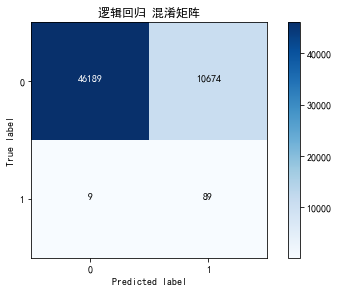

In [18]:
# 调用函数
# 计算混淆矩阵，并显示
cm = confusion_matrix(undersample_ytest, undersample_prediction)
class_names = [0,1]
# 显示混淆矩阵
plot_confusion_matrix(cm, classes = class_names, title = '逻辑回归 混淆矩阵')

### 5.3.4 绘制精准率-召回率曲线

Average precision-recall score: 0.02


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.02')

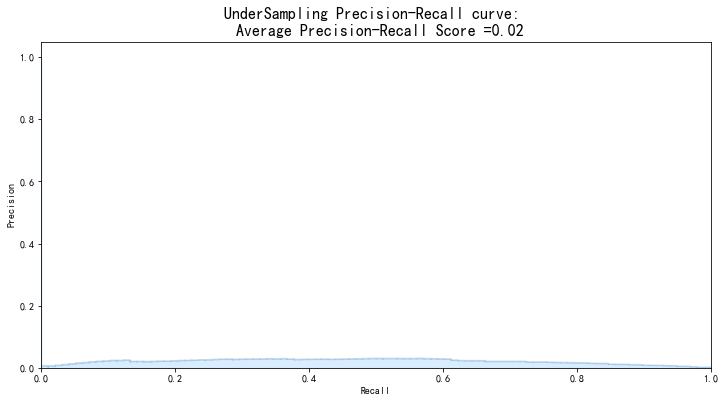

In [19]:
undersample_y_score = best_undersample_est.decision_function(undersample_Xtest)

undersample_average_precision = average_precision_score(undersample_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))


fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)

# 6. 采用过采样的方式（SMOTE算法）进行模型创建、训练与评估

In [20]:
print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# 用于存储评估分数，计算平均值
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

Length of X (train): 227846 | Length of y (train): 227846
Length of X (test): 56961 | Length of y (test): 56961


## 6.1 过采样模型创建

In [21]:
# 默认参数下的逻辑回归器
log_reg_sm = LogisticRegression()

log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# RandomizedSearchCV（随机搜索）可以快速地帮助我们确定一个参数的大概范围，然后我们再使用网格搜索确定参数的精确值。
# 就像警察抓犯人一样，先得快速地确认罪犯的活动区域，然后在该区域内展开地毯式搜索，这样效率更高。
# n_iter：随机寻找参数组合的数量，默认值为10。
rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)

## 6.2 模型训练

In [22]:
for train, test in sss.split(original_Xtrain, original_ytrain):
    # SMOTE 算法用在交叉验证期间，而不是交叉验证之前
    # 定义管道，先对original_Xtrain（227846*30）的80%的数据进行SMOTE处理，再进行RandomizedSearchCV（随机搜索）
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg)

    # 使用SMOTE处理后的翻倍数据进行模型训练
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    # 搜索出最佳模型
    best_est = rand_log_reg.best_estimator_

    # 使用最佳模型对original_Xtrain（227846*30）的20%的数据进行测试
    prediction = best_est.predict(original_Xtrain[test])

    # 存储测试数据
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))

## 6.3 模型评估
### 6.3.1 输出交叉验证结果

In [23]:
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print("auc: {}".format(np.mean(auc_lst)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9426241844562713
precision: 0.06160383645765031
recall: 0.9137293086660175
f1: 0.11359931864558766
auc: 0.9282017234676209
---------------------------------------------------------------------------------------------------------------------------------------


### 6.3.2 输出原始测试集的预测分数

In [24]:
# classification_report()用于显示主要分类指标的文本报告

labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, smote_prediction)
print(oversample_score)
print(classification_report(original_ytest, smote_prediction, target_names=labels))
print('---' * 45)


0.9881673425677218
              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99     56863
       Fraud       0.11      0.85      0.20        98

    accuracy                           0.99     56961
   macro avg       0.56      0.92      0.60     56961
weighted avg       1.00      0.99      0.99     56961

---------------------------------------------------------------------------------------------------------------------------------------


### 6.3.3 可视化混淆矩阵

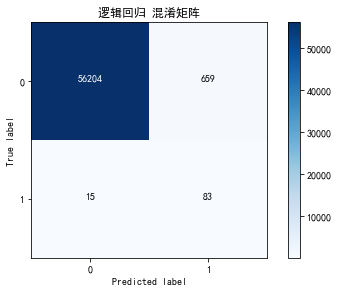

In [25]:
cm = confusion_matrix(original_ytest, smote_prediction)
class_names = [0,1]
# 显示混淆矩阵
plot_confusion_matrix(cm, classes = class_names, title = '逻辑回归 混淆矩阵')

### 6.3.4 绘制精准率-召回率曲线

Average precision-recall score: 0.75


Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.75')

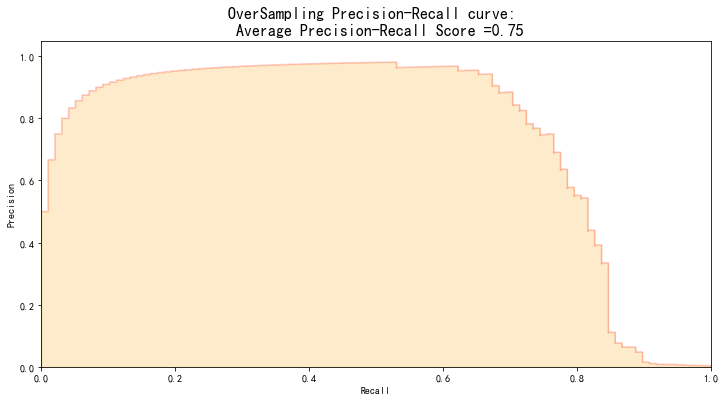

In [26]:
y_score = best_est.decision_function(original_Xtest)

average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))


fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

# 7. 总结
- 不要在交叉验证之前进行过采样或者欠采样，而是应该在交叉验证期间进行，否则会导致过拟合。
- 一般情况下，过采样的效果会比欠采样的效果好，因为欠采样删除了大量的信息，但是过采样会比欠采样所花的时间要多。
